# Spotify EDA and Pre-processing
This notebook explores the results of scraping the Spotify API and pre-processes the data into a form usable for machine learning models.

## Modules, Setup, and Utility Functions

In [3]:
import pickle
import pandas as pd
import glob
import numpy as np
import random
import librosa as lr
import IPython.display as ipd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ipywidgets import IntProgress
from IPython.display import display
import os
from PIL import Image
import re
from collections import Counter
from mpl_toolkits.basemap import Basemap

In [4]:
DATA_PATH = './Data/Spotify/data.pickle'
ALBUMS_PATH = './Data/Spotify/albums/'
AUDIO_PATH = './Data/Spotify/audio/'
LYRICS_PATH = './Data/Spotify/lyrics/'

In [5]:
def check_integrity():
    integrityIsGood = True
    if (set([n[22:-4] for n in glob.glob(ALBUMS_PATH + "*.jpg")]) != set(ALBUMS.index.values)):
        print('Album covers saved to file do not match albums saved to data:')
        print(set([n[22:-4] for n in glob.glob(ALBUMS_PATH + "*.jpg")]).symmetric_difference(set(ALBUMS.index.values)))
        integrityIsGood = False

    if (set([n[21:-4] for n in glob.glob(AUDIO_PATH + "*.mp3")]) != set(TRACKS.index.values)):
        print('Audio saved to file do not match tracks saved to data:')
        print(set([n[21:-4] for n in glob.glob(AUDIO_PATH + "*.mp3")]).symmetric_difference(set(TRACKS.index.values)))
        integrityIsGood = False

    if (set([n[22:-4] for n in glob.glob(LYRICS_PATH + "*.txt")]) != set(TRACKS.index.values)):
        print('Lyrics saved to file do not match tracks saved to data:')
        print(set([n[22:-4] for n in glob.glob(LYRICS_PATH + "*.txt")]).symmetric_difference(set(TRACKS.index.values)))
        integrityIsGood = False

    if (set(TRACKS.artist_id.values) != set(ARTISTS.index.values)):
        print('Some tracks point to artists that dont exist:')
        print(set(TRACKS.artist_id.values).symmetric_difference(set(ARTISTS.index.values)))
        integrityIsGood = False

    if (set(TRACKS.album_id.values) != set(ALBUMS.index.values)):
        print('Some tracks point to albums that dont exist:')
        print(set(TRACKS.album_id.values).symmetric_difference(set(ALBUMS.index.values)))
        integrityIsGood = False
    return integrityIsGood

def delete_track(tracks, artists, albums, track_id):
    artist_id = tracks.loc[track_id].artist_id
    album_id = tracks.loc[track_id].album_id

    os.rename('./Data/Spotify/audio/' + track_id + '.mp3', './Data/Spotify/deleted/' + track_id + '.mp3')
    os.rename('./Data/Spotify/lyrics/' + track_id + '.txt', './Data/Spotify/deleted/' + track_id + '.txt')

    tracks = tracks.drop(track_id)

    if len(tracks.loc[tracks.artist_id == artist_id]) == 0:
        artists = artists.drop(artist_id)

    if len(tracks.loc[tracks.album_id == album_id]) == 0:
        albums = albums.drop(album_id)
        os.rename('./Data/Spotify/albums/' + album_id + '.jpg', './Data/Spotify/deleted/' + album_id + '.jpg')  
        
    return tracks, artists, albums

In [4]:
with open(DATA_PATH, 'rb') as f:
    save = pickle.load(f)
    ARTISTS = save['artists']
    FUTURE_ARTISTS = save['future_artists']
    ALBUMS = save['albums']
    TRACKS = save['tracks']
    del save

In [5]:
check_integrity()

True

## Explore Random Tracks
After exploring many random tracks, the integrity of the data looks good. Tracks, artists, albums, and lyrics seem to match.

In [6]:
random_id = random.choice(TRACKS.index.values)

In [102]:
print(TRACKS.loc[random_id]['name'], 'by', ARTISTS.loc[TRACKS.loc[random_id]['artist_id']]['name'])
print(ALBUMS.loc[TRACKS.loc[random_id]['album_id']]['name'], ALBUMS.loc[TRACKS.loc[random_id]['album_id']]['release_date'][:4])
print(ARTISTS.loc[TRACKS.loc[random_id]['artist_id']]['lat'], ARTISTS.loc[TRACKS.loc[random_id]['artist_id']]['lng'])

Early Train by Dem Atlas
Bad Actress 2018
41.10596779999999 -81.55917819999999


In [103]:
audio, sr = lr.load('./Data/Spotify/audio/' + random_id + '.mp3', sr=22050)
ipd.Audio(data=audio, rate=sr)

In [104]:
with open('./Data/Spotify/lyrics/' + random_id + '.txt', 'r') as f:
    print(f.read())

Oh
I'm taking the early train
I'm making it very plain
I'm taking the easy way out
You know what I'm talking about
I'm taking the early train
I'm making it very plain
I'm taking the easy way out
You know what I'm talking about


I've been to places where the rain is welcome
Glad I talked to God 'til the sunshine he'll come
'Cause when it comes and goes as fast as it shown
Where's the man with the horns and the bargain for your soul
I wanna be alone but I don't wanna be alone
It gets to hard trying to be someone else
I don't need nobody's help
Everyone's a hypocrite
They don't really give a shit
Said I need a therapist
But nah


They don't give me what I want, no
Once I leave I'm gone
They don't give me what I want so
Once I leave I'm gone
Girl where you going?
Nowhere to go, don't leave just close the door
Girl where you going?
Nowhere to go, don't leave just close the door


I'm taking the early train
I'm making it very plain
I'm taking the easy way out
You know what I'm talking about

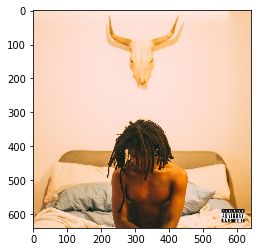

In [105]:
img = mpimg.imread('./Data/Spotify/albums/' + TRACKS.loc[random_id]['album_id'] + '.jpg')
plt.imshow(img)
plt.show()

## Drop Duplicate Indices
Some duplicates have snuck into the dataset, remove them.

In [7]:
TRACKS.loc[TRACKS.index.duplicated()]

,artist_id,album_id,name


In [8]:
TRACKS = TRACKS[~TRACKS.index.duplicated(keep='first')]

In [9]:
ALBUMS.loc[ALBUMS.index.duplicated()]

,artist_id,name,release_date,release_date_precision
3lwu4qs7RJEBRfsDL7aUwu,22ZiDrzGc0fi8wGMaHPmtX,Man of La Mancha (New Broadway Cast Recording ...,2003-01-03,day
2w8GCCMC8uLUBGUYoHAepr,287oKREO3rXSz0r91xbxH6,Sales gones,2012-04-16,day
2kUJgoPA2iz9c2jzUr0y1x,1oK57qVDixqM7no13U1mK9,My Little Pony: The Movie (Original Motion Pic...,2017-09-22,day


In [10]:
ALBUMS = ALBUMS[~ALBUMS.index.duplicated(keep='first')]

In [11]:
ARTISTS.loc[ARTISTS.index.duplicated()]

,name,genres,related,lat,lng


In [12]:
ARTISTS = ARTISTS[~ARTISTS.index.duplicated(keep='first')]

In [13]:
if not check_integrity():
    raise Exception("Integrity compromised!")

## Check Track Lengths
Ensure all tracks are 30s in length, if they are shorter, delete them.

In [14]:
short_tracks = []

In [10]:
progress_bar = IntProgress(min=0, max=len(TRACKS.index.values)) 
display(progress_bar)
for track_id in TRACKS.index.values:
    progress_bar.value += 1
    audio, sr = lr.load('./Data/Spotify/audio/' + track_id + '.mp3', sr=22050, res_type='kaiser_fast')
    if len(audio) // sr < 30:
        short_tracks.append(track_id)
print(len(short_tracks))

IntProgress(value=0)

30


In [16]:
for i in short_tracks:
    TRACKS, ARTISTS, ALBUMS = delete_track(TRACKS, ARTISTS, ALBUMS, i)
    if not check_integrity():
        break

In [17]:
if not check_integrity():
    raise Exception("Integrity compromised!")

## Check Album Art Size
Ensure all album art is 640x640 and RGB. Re-size if not.

In [18]:
bad_albums = []

In [12]:
progress_bar = IntProgress(min=0, max=len(ALBUMS.index.values)) 
display(progress_bar)
for album_id in ALBUMS.index.values:
    progress_bar.value += 1
    img = Image.open('./Data/Spotify/albums/' + album_id + '.jpg')
    if img.size != (640, 640):
        img.save('./Data/Spotify/albums_pre_scaled/' + album_id + '.jpg')
        img = img.resize((640,640))
        img.save('./Data/Spotify/albums/' + album_id + '.jpg')
        bad_albums.append(album_id)
print(len(bad_albums))

IntProgress(value=0, max=10)

5425


In [20]:
if not check_integrity():
    raise Exception("Integrity compromised!")

## Clean Album Years
For older artists, there are usually greatest hits or remastered albums that are released much later than when the artist was active. These skew the year data towards being newer. One way to fix this would be to check if an artists albums span over 40 years, if they do its likely an indication that some of the albums are newer re-releases. In these cases, just change the album year to whatever the earliest album year is associated with that artist. Sometimes the year can be obtained from the album name itself, if that is the case use that year instead of the earliest year. For example:

    Artist: Elvis Presley, Album: The Best of The '68 Comeback Special : 2019 -> 1968
    
If the year of the album is earlier than 1910 and later than this year (2019) check if there are other albums for that artist and use the minimum year, if there are no other albums then delete these tracks.

### Out of Bounds Year Data

In [21]:
changed = True
delete_albums = []

In [22]:
while changed:
    changed = False
    for i, a in ALBUMS.iterrows():
        
        release_date = int(a['release_date'][:4])
        
        if 1910 > release_date or release_date > 2019:
            
            years = []
            albums = ALBUMS.loc[TRACKS.loc[TRACKS.artist_id == a['artist_id']].album_id.values]
            
            for j, l in albums.iterrows():
                y = int(l['release_date'][:4])
                if y != release_date and 1910 < y < 2019:
                    years.append(y)

            if len(years) != 0:
                artist_name = ARTISTS.loc[a['artist_id']]['name']
                album_name = a['name']
                change_year = min(years)

                print(f'Artist: {artist_name}, Album: {album_name} : {release_date} -> {change_year}')
                changed = True

                ALBUMS.loc[i, 'release_date'] = str(change_year)
                ALBUMS.loc[i, 'release_date_precision'] = 'year' 
            elif i not in delete_albums:
                delete_albums.append(i)
                changed = True
print(len(delete_albums))

Artist: Bert Weedon, Album: King Size Guitar : 1899 -> 2010
Artist: Roy Brown, Album: Boogie At Midnight : 1900 -> 1965
Artist: Bernard Cribbins, Album: A Combination Of Cribbins : 1899 -> 2004
Artist: The Four Aces, Album: The Best Of The Four Aces : 1900 -> 2006
Artist: Bobby Troup, Album: Plays Johnny Mercer : 1900 -> 1957
Artist: Bob Scobey, Album: Dixieland Jazz : 1900 -> 2007
Artist: Bobby Short, Album: Bobby Short : 1899 -> 1968
Artist: Bobby Short, Album: Sing Me A Swing Song : 1899 -> 1968
Artist: Bobby Short, Album: Speaking Of Love : 1899 -> 1968
Artist: Bobby Short, Album: Songs By Bobby Short : 1900 -> 1968
Artist: Bobby Short, Album: The Mad Twenties : 1899 -> 1968
Artist: Bunny Berigan, Album: Honeysuckle Rose : 1900 -> 2005
Artist: The Bell Notes, Album: I've Made It : 1899 -> 2010
Artist: Daft Punk, Album: Harder Better Faster Stronger : 1900 -> 1997
Artist: Bukka White, Album: Good Gin Blues : 1899 -> 1970
Artist: Billy Butterfield, Album: 1946-47 : 1900 -> 1978
Artis

In [23]:
delete_tracks = []
for album_id in delete_albums:
    for track_id in TRACKS.loc[TRACKS.album_id == album_id].index.values:
        delete_tracks.append(track_id)
        
for i in delete_tracks:
    TRACKS, ARTISTS, ALBUMS = delete_track(TRACKS, ARTISTS, ALBUMS, i)
    if not check_integrity():
        break

### Eras

In [24]:
def get_eras():
    progress_bar = IntProgress(min=0, max=len(ALBUMS.index.values)) 
    display(progress_bar)
    
    years = pd.DataFrame(columns=['count'])
    
    for index, row in ALBUMS.iterrows():
        progress_bar.value += 1
        year = row['release_date'][:4]
        if year in years.index:
            years.loc[year] += len(TRACKS.loc[TRACKS.album_id == index])
        else:
            years.loc[year] = len(TRACKS.loc[TRACKS.album_id == index])

    eras = {
        '1900s-1940s':0,
        '1950s':0,
        '1960s':0,
        '1970s':0,
        '1980s':0,
        '1990s':0,
        '2000s':0,
        '2010s':0
    }

    for year, count in years.iterrows():
        if int(year) - 2010 > 0:
            eras['2010s'] += count['count']
        elif int(year) - 2000 >= 0:
            eras['2000s'] += count['count']
        elif int(year) - 1990 >= 0:
            eras['1990s'] += count['count']
        elif int(year) - 1980 >= 0:
            eras['1980s'] += count['count']
        elif int(year) - 1970 >= 0:
            eras['1970s'] += count['count']
        elif int(year) - 1960 >= 0:
            eras['1960s'] += count['count']
        elif int(year) - 1950 >= 0:
            eras['1950s'] += count['count']
        else:
            eras['1900s-1940s'] += count['count']
            
    return eras

In [13]:
eras_before = get_eras()

IntProgress(value=0, max=10)

In [26]:
changed = {}
string_years = range(1910,2020)
abbr = ['\''+str(n)[2:] for n in string_years][30:-20]

In [27]:
progress_bar = IntProgress(min=0, max=len(ARTISTS.index.values)) 
display(progress_bar)

for i, a in ARTISTS.iterrows():
    progress_bar.value += 1
    
    years = []
    albums = ALBUMS.loc[TRACKS.loc[TRACKS.artist_id == i].album_id.values]

    maxYear = 0
    for j, l in albums.iterrows():
        y = int(l['release_date'][:4])
        if y > maxYear:
            maxYearID = j
            maxYear = y
        years.append(y)

    while maxYear - min(years) > 35:
        try:
            album_name = ALBUMS.loc[maxYearID]['name'].values[0]
        except:
            album_name = ALBUMS.loc[maxYearID]['name']

        try:
            artist_name = ARTISTS.loc[i]['name'].values[0]
        except:
            artist_name = ARTISTS.loc[i]['name']

        change_year = min(years)

        for y in string_years:
            for s in album_name.split():
                if str(y) in s:
                    change_year = y
                    break

        for h in abbr:
            if h in album_name.split():
                change_year = int('19' + h[1:])
                break

        if change_year == maxYear:
            change_year = min(years)

        print(f'Artist: {artist_name}, Album: {album_name} : {ALBUMS.loc[maxYearID]["release_date"][:4]} -> {change_year}')
        changed[maxYearID] = change_year

        ALBUMS.loc[maxYearID, 'release_date'] = str(change_year)
        ALBUMS.loc[maxYearID, 'release_date_precision'] = 'year' 

        album_name = None
        change_year = None 
              
        years = []
        albums = ALBUMS.loc[TRACKS.loc[TRACKS.artist_id == i].album_id.values]

        maxYear = 0
        for j, l in albums.iterrows():
            y = int(l['release_date'][:4])
            if y > maxYear:
                maxYearID = j
                maxYear = y
            years.append(y)                
len(changed)

IntProgress(value=0, max=26779)

Artist: Fred Buscaglione, Album: Tutto Fred "Che notte" : 2009 -> 1932
Artist: Fred Buscaglione, Album: Carina : 2009 -> 1932
Artist: Fred Buscaglione, Album: L'Italiano In Blues : 2000 -> 1932
Artist: Fred Buscaglione, Album: IL FAVOLOSO FRED BUSCAGLIONE : 1987 -> 1932
Artist: Elvis Presley, Album: The Best of The '68 Comeback Special : 2019 -> 1968
Artist: Aretha Franklin, Album: Dance Vault Remixes : 2006 -> 1967
Artist: Electric Light Orchestra, Album: Jeff Lynne's ELO - Alone in the Universe : 2015 -> 1972
Artist: Robin Trower, Album: Lonesome Road : 2019 -> 1973
Artist: Robin Trower, Album: Tide of Confusion : 2019 -> 1973
Artist: Stiff Little Fingers, Album: 70's Punk Essentials : 2018 -> 1979
Artist: Television, Album: Marquee Moon (Edit) : 2018 -> 1977
Artist: Roy Orbison, Album: Unchained Melodies: Roy Orbison & The Royal Philharmonic Orchestra : 2018 -> 1961
Artist: Roy Orbison, Album: The Essential Roy Orbison : 2006 -> 1961
Artist: Ritchie Valens, Album: La Bamba - Single 

Artist: Stephen Stills, Album: Just Roll Tape - April 26th 1968 : 2007 -> 1968
Artist: Graham Nash, Album: This Path Tonight : 2016 -> 1971
Artist: David Crosby, Album: Sky Trails : 2017 -> 1971
Artist: Jackson C. Frank, Album: Remastered & Unreleased : 2015 -> 1965
Artist: Love, Album: Black Beauty : 2012 -> 1966
Artist: The Zombies, Album: The Original Studio Recordings (Volume One) : 2007 -> 1965
Artist: Them, Album: Complete Them (1964-1967) : 2015 -> 1967
Artist: The Youngbloods, Album: High On a Ridge Top : 2005 -> 1967
Artist: Moby Grape, Album: Listen My Friends! The Best Of Moby Grape : 2007 -> 1967
Artist: Moby Grape, Album: Moby Grape 69' (With Bonus Tracks) : 2007 -> 1967
Artist: John Prine, Album: The Tree of Forgiveness : 2018 -> 1971
Artist: John Prine, Album: Spotify Singles : 2018 -> 1971
Artist: Peter, Paul and Mary, Album: Around The Campfire : 1998 -> 1962
Artist: Sibylle Baier, Album: Colour Green : 2006 -> 1970
Artist: Vashti Bunyan, Album: Bobbie Gentry's The Del

Artist: Corey Hart, Album: Another December / Dreaming Time Again - Single : 2019 -> 1983
Artist: Anvil, Album: Pounding the Pavement : 2018 -> 1981
Artist: Frankie Valli, Album: Love Songs : 2019 -> 1975
Artist: Susan Sarandon, Album: Absolute Treasures: The Rocky Horror Picture Show - The Complete and Definitive Soundtrack (2015 40th Anniversary Re-Mastered Edition) : 2015 -> 1975
Artist: Santana, Album: Ultimate Santana : 2007 -> 1969
Artist: Maurice Jarre, Album: Ghost : 2005 -> 1966
Artist: Tommy James & The Shondells, Album: Crimson & Clover (US Release) : 2005 -> 1966
Artist: Tommy James & The Shondells, Album: The Essentials: Tommy James & The Shondells : 2002 -> 1966
Artist: The Searchers, Album: The Farewell Album: The Greatest Hits & More : 2019 -> 1964
Artist: The Searchers, Album: Needles and Pins : 2014 -> 1964
Artist: The Searchers, Album: The Definitive Pye Collection : 2004 -> 1964
Artist: Sonny & Cher, Album: The Wonderous World Of Sonny & Cher : 2005 -> 1965
Artist: 

Artist: Jimmy Dean, Album: The Complete Mercury & Columbia Singles As & Bs 1955-62 : 2019 -> 1955
Artist: Mickey Gilley, Album: The Essential Mickey Gilley : 2015 -> 1974
Artist: Roy Acuff, Album: Greatest Hits : 2007 -> 1936
Artist: Roy Acuff, Album: Roy Acuff's Greatest Hits : 1994 -> 1936
Artist: Lynn Anderson, Album: The Best Of The Johnny Cash TV Show : 2008 -> 1966
Artist: Lynn Anderson, Album: Geatest Hits : 2004 -> 1966
Artist: New Riders of the Purple Sage, Album: Where I Come From - Radio Mixes & Live Bonus : 2009 -> 1971
Artist: Doug Sahm, Album: Texas Honky-Tonk Blues : 2017 -> 1973
Artist: Michael Nesmith, Album: Infinite Tuesday: Autobiographical Riffs : 2017 -> 1970
Artist: Jesse Colin Young, Album: Song for Juli : 2015 -> 1976
Artist: Jesse Colin Young, Album: The Soul of a City Boy : 2014 -> 1976
Artist: David Bromberg, Album: The Blues, The Whole Blues and Nothing But the Blues : 2016 -> 1972
Artist: Colin Blunstone, Album: Greatest Hits + Plus : 2007 -> 1971
Artist: 

Artist: Adam Sandler, Album: Farley : 2018 -> 1979
Artist: Adam Sandler, Album: Phone Wallet Keys : 2018 -> 1979
Artist: Georges Delerue, Album: Le mépris (Original Movie Soundtrack) – EP : 2016 -> 1961
Artist: Goblin, Album: Suspiria (40th Anniversary) [Original Motion Picture Soundtrack] : 2017 -> 1977
Artist: Goblin, Album: Suspiria (40th Anniversary) [Original Motion Picture Soundtrack] : 2017 -> 1977
Artist: Spin Doctors, Album: If the River Was Whiskey : 2013 -> 1975
Artist: Eric Burdon, Album: House Of The Rising Sun : 2016 -> 1967
Artist: Eric Burdon, Album: The Masters : 2015 -> 1967
Artist: Laurie Anderson, Album: Landfall : 2018 -> 1982
Artist: Jean-Michel Jarre, Album: Equinoxe Infinity : 2018 -> 1978
Artist: Jean-Michel Jarre, Album: Electronica 1: The Time Machine : 2015 -> 1978
Artist: Jean-Michel Jarre, Album: Oxygène : 2015 -> 1978
Artist: City Boy, Album: Young Men Gone West/Book Early : 2015 -> 1978
Artist: City Boy, Album: City Boy/Dinner at the Ritz : 2015 -> 1978


Artist: Tony Christie, Album: Das Beste zum 75. Geburtstag : 2018 -> 1972
Artist: Tony Christie, Album: World Cup Football Anthems : 2010 -> 1972
Artist: Boston Pops Orchestra, Album: America : 2015 -> 1963
Artist: Boston Pops Orchestra, Album: John Williams: The Great Movie Soundtracks : 2013 -> 1963
Artist: Boston Pops Orchestra, Album: 12 Days of Christmas : 2009 -> 1963
Artist: Jimmy Reed, Album: Ain't That Lovin' You Baby : 2007 -> 1965
Artist: Jimmy Reed, Album: The Very Best of Jimmy Reed : 2003 -> 1965
Artist: Miriam Makeba, Album: Pata Pata : 2017 -> 1960
Artist: Miriam Makeba, Album: Keep Me In Mind : 2017 -> 1960
Artist: Miriam Makeba, Album: Reflections : 2003 -> 1960
Artist: Mickey Newbury, Album: An American Trilogy : 2011 -> 1968
Artist: Gilberto Gil, Album: Trinca de Ases (Ao Vivo) : 2018 -> 1969
Artist: Gilberto Gil, Album: Dois Amigos, Um Século de Música: Multishow Live : 2016 -> 1969
Artist: Gilberto Gil, Album: Dois Amigos, um Século de Música (Ao Vivo) : 2015 -> 1

Artist: Markéta Irglová, Album: River : 2018 -> 1968
Artist: Markéta Irglová, Album: Muna : 2014 -> 1968
Artist: Markéta Irglová, Album: Music From The Motion Picture Once : 2007 -> 1968
Artist: Markéta Irglová, Album: The Swell Season : 2006 -> 1968
Artist: Azymuth, Album: Azimüth : 2014 -> 1977
Artist: Capital Letters, Album: Vinyard : 2015 -> 1979
Artist: Eddie Cantor, Album: The Naughty 1920s: Red Hot & Risque Songs of The Jazz Age, Vol. 1 : 2012 -> 1920
Artist: Eddie Cantor, Album: Eddie Cantor Greatest Hits : 2011 -> 1920
Artist: Eddie Cantor, Album: The Columbia Years: 1922-1940 : 1994 -> 1940
Artist: Eddie Cantor, Album: Pop Music: The Early Years 1890-1950 : 1972 -> 1950
Artist: Paper Lace, Album: The Night Chicago Died : 2012 -> 1970
Artist: Paper Lace, Album: Billy Don't Be A Hero : 2008 -> 1970
Artist: Paper Lace, Album: Paper Lace - Their Very Best : 2008 -> 1970
Artist: Conway Twitty, Album: Number 1's and More : 2019 -> 1982
Artist: Claude François, Album: Claude Françoi

Artist: Los Panchos, Album: El Trío Los Panchos / Por Siempre Boleros : 2014 -> 1964
Artist: Los Panchos, Album: Epoca de Oro Volúmen Tres : 2012 -> 1964
Artist: Graham Gouldman, Album: Love and Work : 2012 -> 1968
Artist: Bill Monroe, Album: Live 1964 : 2014 -> 1964
Artist: Bill Monroe, Album: The Early Years : 2013 -> 1946
Artist: Bill Monroe, Album: High Lonesome: The Story of Bluegrass Music : 2008 -> 1946
Artist: Bill Monroe, Album: Live At Mechanics Hall : 2004 -> 1946
Artist: Bill Monroe, Album: Greatest Hits : 2003 -> 1946
Artist: Bill Monroe, Album: Greatest Hits : 2001 -> 1946
Artist: Bill Monroe, Album: Bill Monroe: Live From Mountain Stage : 1999 -> 1946
Artist: Malvina Reynolds, Album: Little Boxes and Magic Pennies: an Anthology of Children's Songs : 2017 -> 1967
Artist: Stampeders, Album: Sweet City Woman : 2016 -> 1971
Artist: Freddy Cole, Album: My Mood Is You : 2018 -> 1976
Artist: Billy Strange, Album: Great Western Themes : 2004 -> 1964
Artist: Helen Humes, Album: B

Artist: Johnny "Hammond" Smith, Album: The Essential Grover Washington, Jr.: The Columbia Years : 2013 -> 1971
Artist: Johnny "Hammond" Smith, Album: Essential Jazz Collection : 2012 -> 1971
Artist: Jorge Negrete, Album: 50 Aniversario Luctuoso - Jorge Negrete "El Charro Cantor" Vol. 3 : 2004 -> 1957
Artist: Jorge Negrete, Album: Jorge Negrete. Sus 40 Grandes Canciones (1911-1953) : 2002 -> 1953
Artist: Jorge Negrete, Album: Lo Mejor De Jorge Negrete : 2001 -> 1953
Artist: Jorge Negrete, Album: Coleccion Original : 1998 -> 1953
Artist: Jorge Negrete, Album: Fiesta Mexicana : 1992 -> 1953
Artist: Owe Thörnqvist, Album: Det bästa med Owe Thörnqvist - Knock & Roll : 2017 -> 1960
Artist: Doc Watson, Album: Doc & Dawg (Live @ Acoustic Stage 1997) : 2018 -> 1997
Artist: Doc Watson, Album: Doc's Guitar : 2017 -> 1964
Artist: Doc Watson, Album: Live In Watsonville : 2014 -> 1964
Artist: Doc Watson, Album: Top 20 Christmas - Country : 2013 -> 1964
Artist: Doc Watson, Album: The Legendary Doc Wa

Artist: Georgie Fame, Album: The Best Music from Jamaica : 2013 -> 1966
Artist: Lukas Nelson, Album: My Little Pony: The Movie (Original Motion Picture Soundtrack) : 2017 -> 1970
Artist: Henson Cargill, Album: Some Favorite Songs : 2015 -> 1968
Artist: Henson Cargill, Album: Henson Cargill - His Very Best : 2007 -> 1968
Artist: Julio Sosa, Album: Grandes Éxitos De : 2018 -> 1961
Artist: Julio Sosa, Album: En Esta Tarde Gris : 2015 -> 1961
Artist: Ed Ames, Album: The Very Best Of Ed Ames : 2001 -> 1965
Artist: Marilyn Monroe, Album: Marilyn Monroe 50th Anniversary Album : 2012 -> 1960
Artist: Marilyn Monroe, Album: Diamonds Are a Girl's Best Friend : 2012 -> 1960
Artist: Marilyn Monroe, Album: The Essentials : 2006 -> 1960
Artist: Marilyn Monroe, Album: The Magic of Marilyn : 2001 -> 1960
Artist: Yves Montand, Album: Evolution of Jazz - The 40's : 2011 -> 1955
Artist: Yves Montand, Album: Hôtel Costes : 1999 -> 1955
Artist: Yves Montand, Album: Sous Le Cial De Paris : 1991 -> 1955
Artis

Artist: Leo Dan, Album: Leo Dan : 2003 -> 1964
Artist: Leo Dan, Album: Exitos en Vivo Vol. Ii : 2002 -> 1964
Artist: Leo Dan, Album: Exitos en Vivo Vol. I : 2002 -> 1964
Artist: Leo Dan, Album: Exitos Con Mariachi : 2002 -> 1964
Artist: Los Rebeldes Del Rock, Album: Historia Musical de Mis Exitos : 2013 -> 1969
Artist: José Luis Rodríguez, Album: Inmenso : 2017 -> 1974
Artist: Luiz Melodia, Album: Luiz Melodia Especial MTV (Ao Vivo) : 2012 -> 1976
Artist: Jeanne Moreau, Album: Le tourbillon de ma vie (Best Of 2017) : 2017 -> 1981
Artist: Manna Dey, Album: Masterworks Lata Mangeshkar : 2018 -> 1955
Artist: Manna Dey, Album: Indian Summer - Classic Artist Series, Vol. 5 : 2015 -> 1955
Artist: Hemant Kumar, Album: Hemant Kumar the Legend of India (Bollywood Songs) : 2011 -> 1952
Artist: Freddie Hubbard, Album: The Hub of Hubbard (192 Khz) : 2016 -> 1967
Artist: De Spelbrekers, Album: Hollands Glorie - De Spelbrekers : 2006 -> 1956
Artist: Asha Bhosle, Album: Suron Ki Mallika - Asha Bhosle

Artist: Georgia Gibbs, Album: Silent Lips : 2011 -> 1966
Artist: Eddie Fisher, Album: Greatest Hits : 2005 -> 1966
Artist: The Hilltoppers, Album: A Fallen Tear : 2011 -> 1939
Artist: The Hilltoppers, Album: No Regrets : 2011 -> 1939
Artist: Ian Campbell Folk Group, Album: The Times They Are a-Changin' : 2005 -> 1964
Artist: Jane Morgan, Album: Essential Masters : 2013 -> 1939
Artist: Jane Morgan, Album: Jane in Spain : 2013 -> 1939
Artist: Anita Bryant, Album: On Rute 66 : 2014 -> 1968
Artist: Skeeter Davis, Album: Skeeter Davis: The Pop Hits Collection, Volume 1 : 2003 -> 1963
Artist: Skeeter Davis, Album: Skeeter Davis: RCA Country Legend : 2001 -> 1963
Artist: The Boswell Sisters, Album: The Boswell Sisters Swing! : 2010 -> 1950
Artist: The Boswell Sisters, Album: Bowsell Sisters : 2008 -> 1950
Artist: The Boswell Sisters, Album: The Boswell Sisters Volume 1 : 2007 -> 1950
Artist: The Boswell Sisters, Album: That's How Rhythm Was Born : 1995 -> 1950
Artist: Brook Benton, Album: The

Artist: Claude Thornhill & His Orchestra, Album: Best of the Claude Thornhill Orchestra : 2013 -> 1932
Artist: Herbie Hancock, Album: The Imagine Project : 2009 -> 1917
Artist: Herbie Hancock, Album: Future Shock : 1983 -> 1917
Artist: The Manhattan Transfer, Album: Mum : 2013 -> 1975
Artist: Orquestra Imperial, Album: Fazendo As Pazes Com o Swing : 2015 -> 1970
Artist: Eddie "Lockjaw" Davis, Album: This Little Love : 2018 -> 1977
Artist: Eddie "Lockjaw" Davis, Album: Big Band : 2015 -> 1977
Artist: Eddie "Lockjaw" Davis, Album: The Complete Recordings: 1953-1959 : 2014 -> 1959
Artist: Eddie "Lockjaw" Davis, Album: The Complete Recordings: 1961-1962 : 2014 -> 1962
Artist: Eddie "Lockjaw" Davis, Album: The Complete Recordings: 1959-1960 : 2014 -> 1960
Artist: Eddie "Lockjaw" Davis, Album: Eddie Davis Trio Featuring Shirley Scott Complete Recordings : 2004 -> 1959
Artist: Eddie "Lockjaw" Davis, Album: That's all : 2003 -> 1959
Artist: Eddie "Lockjaw" Davis, Album: Eddie's Function : 2000

Artist: Jeanette, Album: Ritual Chants : 2017 -> 1981
Artist: Charlie Walker, Album: Famous Country Songs : 2015 -> 1965
Artist: Charlie Walker, Album: Country Hits of the 80s : 2013 -> 1965
Artist: Ethel Ennis, Album: Lullabies for Losers - Change of Scenery - Have You Forgotten? : 2012 -> 1964
Artist: Barnes & Barnes, Album: Zabagabee - The Best of Barnes & Barnes : 2018 -> 1981
Artist: Marcel Amont, Album: Les bleuets d'azur : 2018 -> 1959
Artist: Marcel Amont, Album: Restons Groupés - Bande originale du film : 1998 -> 1959
Artist: Peter Maffay, Album: Tattoos (40 Jahre Maffay - Alle Hits - Neu produziert) : 2010 -> 1970
Artist: Peter Maffay, Album: Sonne in der Nacht : 2006 -> 1970
Artist: Edna St. Vincent Millay, Album: 100 Great Poems - Classic Poets & Beatnik Freaks : 2012 -> 1955
Artist: Cheo Feliciano, Album: Sentimiento, tu : 2009 -> 1971
Artist: Cheo Feliciano, Album: A Man And His Music : 2009 -> 1971
Artist: Stern-Combo Meißen, Album: Weißes Gold (Jubiläums Edition) : 2018

1520

In [14]:
eras_after = get_eras()

IntProgress(value=0, max=10)

In [29]:
print(f"1900s-1940s : {eras_before['1900s-1940s']} -> {eras_after['1900s-1940s']}")
print(f"1950s : {eras_before['1950s']} -> {eras_after['1950s']}")
print(f"1960s : {eras_before['1960s']} -> {eras_after['1960s']}")
print(f"1970s : {eras_before['1970s']} -> {eras_after['1970s']}")
print(f"1980s : {eras_before['1980s']} -> {eras_after['1980s']}")
print(f"1990s : {eras_before['1990s']} -> {eras_after['1990s']}")
print(f"2000s : {eras_before['2000s']} -> {eras_after['2000s']}")
print(f"2010s : {eras_before['2010s']} -> {eras_after['2010s']}")

1900s-1940s : 201 -> 545
1950s : 455 -> 889
1960s : 2180 -> 3076
1970s : 4621 -> 5418
1980s : 7399 -> 7483
1990s : 17947 -> 17775
2000s : 47381 -> 46480
2010s : 78828 -> 77346


### Get Mean Artist Year

In [30]:
artist_year = {}
years = []

progress_bar = IntProgress(min=0, max=len(ARTISTS.index.values)) 
display(progress_bar)

for artist_id, artist in ARTISTS.iterrows():
    progress_bar.value += 1
    
    y = []
    albums = ALBUMS.loc[TRACKS.loc[TRACKS.artist_id == artist_id].album_id.values]

    for j, l in albums.iterrows():
        y.append(int(l['release_date'][:4]))
        
    artist_year[artist_id] = int(np.mean(y))
    years.append(int(np.mean(y)))
    
counts = Counter(years)
years_sorted = sorted(counts, key=counts.get, reverse=True)
years_sorted[:10]

IntProgress(value=0, max=26779)

[2017, 2016, 2015, 2014, 2013, 2018, 2012, 2011, 2010, 2009]

In [31]:
counts = Counter(years)
years_sorted = sorted(counts, key=counts.get, reverse=False)
years_sorted[:10]

[1920, 1940, 1942, 1938, 1925, 1926, 1924, 1917, 1921, 1944]

### View Random Year

In [114]:
artist_id = random.choice(list(ARTISTS[:1000].index.values))
print(ARTISTS.loc[artist_id]['name'], artist_year[artist_id])

Lou Reed 1975


## Clean Lyrics
Check for non-lyric descriptive words such as \[Chorus\] and \[Verse\] by just checking anything between brackets or parentheses under a certain length. Remove these descriptive words. 

If the lyric was found by Musixmatch, its only going to have 30% of the lyrics because Musixmatch is a paid API. It is assumed that lyrics are usually repetitive so doubling the lyrics we do have is a good way to estimate the lyrical content. 

Inspect the word count to determine if anything looks off. If the amount of characters in a lyrics file is less than 30, assume that it is an instrumental song and truncate the file contents.

In [15]:
def clean_lyric(lyric):
    removed = []
    
    removed.extend(re.findall(re.compile(r'\[.{,40}\]', re.IGNORECASE), lyric))
    removed.extend(re.findall(re.compile(r'\{.{,40}\}', re.IGNORECASE), lyric))
    removed.extend(re.findall(re.compile(r'x\d{1,2}', re.IGNORECASE), lyric))
    removed.extend(re.findall(re.compile(r'\d{1,2}x', re.IGNORECASE), lyric))
    
    removed.extend(re.findall(re.compile(r'\(Produced by.*\)', re.IGNORECASE), lyric))
    removed.extend(re.findall(re.compile(r'\(Interlude.*\)', re.IGNORECASE),lyric))
    removed.extend(re.findall(re.compile(r'\(Chorus.*\)', re.IGNORECASE), lyric))
    removed.extend(re.findall(re.compile(r'\(Verse.*\)', re.IGNORECASE), lyric))
    removed.extend(re.findall(re.compile(r'\(Chorus.*\)', re.IGNORECASE), lyric))
    removed.extend(re.findall(re.compile(r'\(Pre-Chorus.*\)', re.IGNORECASE), lyric))
    removed.extend(re.findall(re.compile(r'\(Bridge.*\)', re.IGNORECASE), lyric))
    removed.extend(re.findall(re.compile(r'\(Outro.*\)', re.IGNORECASE), lyric))
    removed.extend(re.findall(re.compile(r'\(Pre.*\)', re.IGNORECASE), lyric))
    removed.extend(re.findall(re.compile(r'\(Hook.*\)', re.IGNORECASE), lyric))
    removed.extend(re.findall(re.compile(r'\(Sample.*\)', re.IGNORECASE), lyric))
    removed.extend(re.findall(re.compile(r'\(Refrain.*\)', re.IGNORECASE), lyric))
    removed.extend(re.findall(re.compile(r'\(Repeat.*\)', re.IGNORECASE), lyric))
    removed.extend(re.findall(re.compile(r'\(Intro.*\)', re.IGNORECASE), lyric))
    removed.extend(re.findall(re.compile(r'\(Part.*\)', re.IGNORECASE), lyric))
    removed.extend(re.findall(re.compile(r'\(Breakdown.*\)', re.IGNORECASE), lyric))

    removed.extend(re.findall(re.compile(r'Produced by:', re.IGNORECASE), lyric))
    removed.extend(re.findall(re.compile(r'Interlude:', re.IGNORECASE), lyric))
    removed.extend(re.findall(re.compile(r'Chorus:', re.IGNORECASE), lyric))
    removed.extend(re.findall(re.compile(r'Verse:', re.IGNORECASE), lyric))
    removed.extend(re.findall(re.compile(r'Chorus:', re.IGNORECASE), lyric))
    removed.extend(re.findall(re.compile(r'Pre-Chorus:', re.IGNORECASE), lyric))
    removed.extend(re.findall(re.compile(r'Bridge:', re.IGNORECASE), lyric))
    removed.extend(re.findall(re.compile(r'Outro:', re.IGNORECASE), lyric))
    removed.extend(re.findall(re.compile(r'Pre:', re.IGNORECASE), lyric))
    removed.extend(re.findall(re.compile(r'Hook:', re.IGNORECASE), lyric))
    removed.extend(re.findall(re.compile(r'Sample:', re.IGNORECASE), lyric))
    removed.extend(re.findall(re.compile(r'Refrain:', re.IGNORECASE), lyric))
    removed.extend(re.findall(re.compile(r'Repeat:', re.IGNORECASE), lyric))
    removed.extend(re.findall(re.compile(r'Intro:', re.IGNORECASE), lyric))
    removed.extend(re.findall(re.compile(r'Part:', re.IGNORECASE), lyric))
    removed.extend(re.findall(re.compile(r'Breakdown:', re.IGNORECASE), lyric))
    
    removed.extend(''.join([c for c in lyric if c in '!"#$%&\'’()*+,-./:;<=>?@[\\]^_`{|}~']))
    
    lyric = re.sub(re.compile(r'\[.{,40}\]', re.IGNORECASE), '', lyric)
    lyric = re.sub(re.compile(r'\{.{,40}\}', re.IGNORECASE), '', lyric)
    lyric = re.sub(re.compile(r'x\d{1,2}', re.IGNORECASE), '', lyric)
    lyric = re.sub(re.compile(r'\d{1,2}x', re.IGNORECASE), '', lyric)
    
    lyric = re.sub(re.compile(r'\(Produced by.*\)', re.IGNORECASE), '', lyric)
    lyric = re.sub(re.compile(r'\(Interlude.*\)', re.IGNORECASE), '', lyric)
    lyric = re.sub(re.compile(r'\(Chorus.*\)', re.IGNORECASE), '', lyric)
    lyric = re.sub(re.compile(r'\(Verse.*\)', re.IGNORECASE), '', lyric)
    lyric = re.sub(re.compile(r'\(Chorus.*\)', re.IGNORECASE), '', lyric)
    lyric = re.sub(re.compile(r'\(Pre-Chorus.*\)', re.IGNORECASE), '', lyric)
    lyric = re.sub(re.compile(r'\(Bridge.*\)', re.IGNORECASE), '', lyric)
    lyric = re.sub(re.compile(r'\(Outro.*\)', re.IGNORECASE), '', lyric)
    lyric = re.sub(re.compile(r'\(Pre.*\)', re.IGNORECASE), '', lyric)
    lyric = re.sub(re.compile(r'\(Hook.*\)', re.IGNORECASE), '', lyric)
    lyric = re.sub(re.compile(r'\(Sample.*\)', re.IGNORECASE), '', lyric)
    lyric = re.sub(re.compile(r'\(Refrain.*\)', re.IGNORECASE), '', lyric)
    lyric = re.sub(re.compile(r'\(Repeat.*\)', re.IGNORECASE), '', lyric)
    lyric = re.sub(re.compile(r'\(Intro.*\)', re.IGNORECASE), '', lyric)
    lyric = re.sub(re.compile(r'\(Part.*\)', re.IGNORECASE), '', lyric)
    lyric = re.sub(re.compile(r'\(Breakdown.*\)', re.IGNORECASE), '', lyric)
    
    lyric = re.sub(re.compile(r'Produced by:', re.IGNORECASE), '', lyric)
    lyric = re.sub(re.compile(r'Interlude:', re.IGNORECASE), '', lyric)
    lyric = re.sub(re.compile(r'Chorus:', re.IGNORECASE), '', lyric)
    lyric = re.sub(re.compile(r'Verse:', re.IGNORECASE), '', lyric)
    lyric = re.sub(re.compile(r'Chorus:', re.IGNORECASE), '', lyric)
    lyric = re.sub(re.compile(r'Pre-Chorus:', re.IGNORECASE), '', lyric)
    lyric = re.sub(re.compile(r'Bridge:', re.IGNORECASE), '', lyric)
    lyric = re.sub(re.compile(r'Outro:', re.IGNORECASE), '', lyric)
    lyric = re.sub(re.compile(r'Pre:', re.IGNORECASE), '', lyric)
    lyric = re.sub(re.compile(r'Hook:', re.IGNORECASE), '', lyric)
    lyric = re.sub(re.compile(r'Sample:', re.IGNORECASE), '', lyric)
    lyric = re.sub(re.compile(r'Refrain:', re.IGNORECASE), '', lyric)
    lyric = re.sub(re.compile(r'Repeat:', re.IGNORECASE), '', lyric)
    lyric = re.sub(re.compile(r'Intro:', re.IGNORECASE), '', lyric)
    lyric = re.sub(re.compile(r'Part:', re.IGNORECASE), '', lyric)
    lyric = re.sub(re.compile(r'Breakdown:', re.IGNORECASE), '', lyric)
    
    lyric = ''.join([c for c in lyric if c not in '!"#$%&\'’()*+,-./:;<=>?@[\\]^_`{|}~'])
    
    lyric = lyric.lower()
    
    if len(lyric) < 30:
        removed.extend(lyric)
        lyric = ''
        
    return lyric, removed

In [16]:
LYRICS_FOUND_BY_MM = '681F1AF6-8A1A-4493-8020-E44E2006ADB1***LYRICS_FOUND_BY_MM***361E1163-EE9C-444D-874D-7E0D438EF459'

In [17]:
lyrics = {}
lyrics_removed = {}
lyrics_mm = []
words_list = []

progress_bar = IntProgress(min=0, max=len(TRACKS.index.values)) 
display(progress_bar)

for track_id in TRACKS.index.values:
    progress_bar.value += 1
    
    with open('./Data/Spotify/lyrics/' + track_id + '.txt', 'r') as f:
        lyric = f.read()
        if LYRICS_FOUND_BY_MM in lyric:
            lyrics_mm.append(track_id)
            
            # Replace LYRICS_FOUND_BY_MM with empty string
            lyric = lyric.replace(LYRICS_FOUND_BY_MM, '')
            lyric = lyric.replace('...', '')
            
            # Clean lyric
            lyric, removed = clean_lyric(lyric)
            
            # Because this is Musixmatch, double the lyric content
            lyric = lyric*2
            
            # Set the lyric content
            lyrics[track_id] = lyric
            lyrics_removed[track_id] = removed
            words_list.extend(lyric.split())
        else:
            # Clean lyric
            lyric, removed = clean_lyric(lyric)
            
            # Set the lyric content
            lyrics[track_id] = lyric
            lyrics_removed[track_id] = removed
            words_list.extend(lyric.split())

IntProgress(value=0, max=159012)

In [18]:
counts = Counter(words_list)
vocab = sorted(counts, key=counts.get, reverse=True)
vocab_to_int = {word: i for i, word in enumerate(vocab, 1)}
int_to_vocab = {i: word for word, i in vocab_to_int.items()}
print('Number of songs:', len(lyrics))
print('Number of Musixmatch songs:', len(lyrics_mm), f'/ {(len(lyrics_mm)/len(lyrics))*100:.2f}%')
print('Unique words:', len((vocab_to_int)))

Number of songs: 159012
Number of Musixmatch songs: 12316 / 7.75%
Unique words: 497946


### View Random Lyrics

In [19]:
def encode_lyric(lyric):
    int_list = []
    for word in lyric.split():
        int_list.append(vocab_to_int[word])
    
    vocab_list = []
    for i in int_list:
        vocab_list.append(int_to_vocab[i])
    
    return int_list, vocab_list

In [42]:
track_id = random.choice(list(TRACKS.index.values))
int_list, vocab_list = encode_lyric(lyrics[track_id])
print(lyrics[track_id])
print(lyrics_removed[track_id])
print()
print(int_list)
print(vocab_list)

pressure pushing down on me
pressing down on you no man ask for
under pressure  that burns a building down splits a
family in two
puts people on streets

thats ok
its the terror of knowing what this world is about
watching some good friends screaming let me out
pray tomorrow  gets me higher
pressure on people  people on streets
chippin around  kick my brains around the floor
these are the days it never rains but it pours
people on streets twice

its the terror of knowing what this world is about
watching some good friends screaming let me out
pray tomorrow  gets me higher
pressure on people  people on streets

turned away from it all like a blind man
sat on a fence but it dont work
keep coming up with love but its so slashed and torn
whywhywhy
love
insanity laughs under pressure were cracking

cant we give ourselves one more chance
why cant we give love that one more chance
why cant we give love
cause loves such an old fashioned word
and love dares you to care for the people on the edg

## Inspect Locations
Inspect the locations of where the artists were born or where the artist originated. Use the world cities data to estimate the country. This may be a poor estimate of country because of the ordering of the WORLD_CITIES data (especially in Europe where countries are numerous and small).

In [56]:
WORLD_CITIES = pd.read_csv(
    './Data/Spotify/worldcities.csv'
)
int_lat, int_lng = [], []
for index, row in WORLD_CITIES.iterrows():
    int_lat.append(int(row['lat']))
    int_lng.append(int(row['lng']))

WORLD_CITIES['int_lat'] = int_lat
WORLD_CITIES['int_lng'] = int_lng

def get_country(lat, lng):

    close_cities = WORLD_CITIES.loc[WORLD_CITIES.int_lat == int(lat)].loc[WORLD_CITIES.int_lng == int(lng)]
    
    country = None
                 
    if len(close_cities) == 0:
        city = None
        for tol in [0.1, 1, 10]:
            for _, row in WORLD_CITIES.iterrows():
                if (abs(row['lat'] - lat) <= tol) and (abs(row['lng'] - lng) <= tol):
                    city = row
                    break
        if city is not None:
            country = city.country
    
    elif len(close_cities) == 1:
        country = close_cities.country.values[0]
                 
    else:
        city = None
        for tol in [0.1, 1, 10]:
            for _, row in close_cities.iterrows():
                if (abs(row['lat'] - lat) <= tol) and (abs(row['lng'] - lng) <= tol):
                    city = row
                    break
        if city is not None:
            country = city.country

    return country

In [57]:
artist_country = {}
lats = []
lngs = []

progress_bar = IntProgress(min=0, max=len(ARTISTS.index.values)) 
display(progress_bar)

for artist_id, artist in ARTISTS.iterrows():
    progress_bar.value += 1
    
    try:
        lats.append(artist['lat'])
        lngs.append(artist['lng'])

        artist_country[artist_id] = get_country(artist['lat'], artist['lng'])
    except Exception as e:
        print(e)
        print(artist_id)
    
print(len(ARTISTS), len(lats), len(lngs), len(artist_country))

IntProgress(value=0, max=26779)

26779 26779 26779 26779


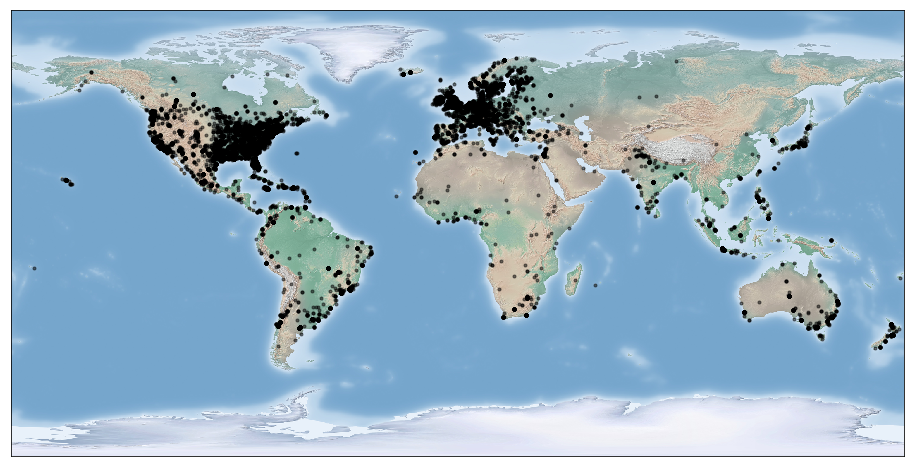

In [58]:
fig = plt.figure(figsize=(16, 12), edgecolor='w')
m = Basemap(projection='cyl', resolution=None,
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180, )
m.shadedrelief(scale=0.2)
m.scatter(lngs, lats, latlon=True, marker='.', color='k', alpha=0.5)
plt.show()

In [59]:
counts = Counter([c for _, c in artist_country.items()])
countries_sorted = sorted(counts, key=counts.get, reverse=True)
countries_sorted[:10]

['United States',
 'United Kingdom',
 'Canada',
 'Australia',
 'Netherlands',
 'Lithuania',
 'Germany',
 'Mexico',
 'Sweden',
 'Kosovo']

In [60]:
counts = Counter([c for _, c in artist_country.items()])
countries_sorted = sorted(counts, key=counts.get, reverse=False)
countries_sorted[:10]

['Belize',
 'Mozambique',
 'Guyana',
 'Fiji',
 'Saint Barthelemy',
 'Timor-Leste',
 'Grenada',
 'Congo (Kinshasa)',
 'Central African Republic',
 'Montserrat']

### View Random Location

In [46]:
artist_id = random.choice(list(ARTISTS.index.values))
print(ARTISTS.loc[artist_id]['name'], artist_country[artist_id])

Modest Mouse United States


## Inspect Genres
Inspect the artist genres. Get a random genre from the list of genres given to an artist.

In [43]:
artist_genre = {}
genres = []

for artist_id, artist in ARTISTS.iterrows():
    if len(artist['genres']) > 0:
        artist_genre[artist_id] = random.choice(artist['genres'])
        genres.extend(artist['genres'])
    
print(len(ARTISTS), len(artist_genre), len(genres))

26779 22464 76227


In [44]:
counts = Counter(genres)
genres_sorted = sorted(counts, key=counts.get, reverse=True)
genres_sorted[:10]

['indie rock',
 'modern rock',
 'folk-pop',
 'rock',
 'dance pop',
 'pop rap',
 'pop',
 'hip hop',
 'indie pop',
 'alternative rock']

In [45]:
counts = Counter(genres)
genres_sorted = sorted(counts, key=counts.get, reverse=False)
genres_sorted[:10]

['neo-proto',
 'trival',
 'springfield mo indie',
 'cinematic post-rock',
 'delaware indie',
 'batak',
 'polish black metal',
 'arab folk',
 'maskandi',
 'nz punk']

### View Random Genres

In [62]:
artist_id = random.choice(list(ARTISTS[:1000].index.values))
print(ARTISTS.loc[artist_id]['name'], artist_genre[artist_id])

Mick Jenkins rap


## Split
Split data into training, validation, and test sets. Use a greedy snag approach to split the data maintaining healthy ratios of eras, locations, and genres.

In [81]:
year_artist = {year: [] for year in years_sorted}
for artist, year in artist_year.items():
    year_artist[year].append(artist)

artists_sorted_by_year = []
for _, artists in year_artist.items():
    artists_sorted_by_year.extend(artists)

country_artist = {country: [] for country in countries_sorted}
for artist, country in artist_country.items():
    country_artist[country].append(artist)

artists_sorted_by_country = []
for _, artists in country_artist.items():
    artists_sorted_by_country.extend(artists)
    
genre_artist = {genre: [] for genre in genres_sorted}
for artist, genre in artist_genre.items():
    genre_artist[genre].append(artist)
    
artists_sorted_by_genre = []
for _, artists in genre_artist.items():
    artists_sorted_by_genre.extend(artists)  

artists = set(ARTISTS.index.values)
splits = {}

while len(artists) > 0:
    # Get first 10 years, countries, genres
    y = set(artists_sorted_by_year[:10])
    c = set(artists_sorted_by_country[:10])
    g = set(artists_sorted_by_genre[:10])
    
    # Remove first 10 years, countries, genres
    del artists_sorted_by_year[:10]
    del artists_sorted_by_country[:10]
    del artists_sorted_by_genre[:10]
    
    # Remove chosen artists from artists set
    artists = artists - (y | c | g)
    
    # Remove chosen artists from other descriptive sets
    for i in y:
        if i in artists_sorted_by_country:
            artists_sorted_by_country.remove(i)
        if i in artists_sorted_by_genre:
            artists_sorted_by_genre.remove(i)
            
    for i in c:
        if i in artists_sorted_by_year:
            artists_sorted_by_year.remove(i)
        if i in artists_sorted_by_genre:
            artists_sorted_by_genre.remove(i)
            
    for i in g:
        if i in artists_sorted_by_year:
            artists_sorted_by_year.remove(i)
        if i in artists_sorted_by_country:
            artists_sorted_by_country.remove(i)
            
    # Remove any duplicates within the chosen sets
    g = g - (c | y)
    c = c - y
    
    # For each descriptive set
    # grab one random artist for the test and val sets 
    # leave the rest for the training set
    for ds in [y, c, g]:
        if len(ds) > 0:
            test = random.choice(list(ds))
            ds.remove(test)
            splits[test] = 'test'
            
        if len(ds) > 0:
            val = random.choice(list(ds))
            ds.remove(val)
            splits[val] = 'val'
        
        for train in ds:
            splits[train] = 'train'

In [82]:
count_test = 0
count_val = 0
count_train = 0
for artist_id, split in splits.items():
    if split == 'test':
        count_test += len(TRACKS.loc[TRACKS.artist_id == artist_id])
    if split == 'train':
        count_train += len(TRACKS.loc[TRACKS.artist_id == artist_id])
    if split == 'val':
        count_val += len(TRACKS.loc[TRACKS.artist_id == artist_id])

In [85]:
print(f'Training {count_train}, Validation {count_val}, Testing {count_test}')
print(f'Training {count_train/len(TRACKS):.2f}, Validation {count_val/len(TRACKS):.2f}, Testing {count_test/len(TRACKS):.2f}')

Training 126452, Validation 16482, Testing 16078
Training 0.80, Validation 0.10, Testing 0.10


In [86]:
test_artist = {}
train_artist = {}
val_artist = {}
for year in years_sorted:
    test_artist[year] = 0
    train_artist[year] = 0
    val_artist[year] = 0
    
for artist_id, split in splits.items():
    if split == 'test':
        test_artist[artist_year[artist_id]] += 1
    if split == 'train':
        train_artist[artist_year[artist_id]] += 1
    if split == 'val':
        val_artist[artist_year[artist_id]] += 1
        
print('Year, Train, Validation, Test')
for year in years_sorted:
    print(year, ':', train_artist[year], val_artist[year], test_artist[year])

Year, Train, Validation, Test
1920 : 1 0 0
1940 : 0 1 0
1942 : 1 0 0
1938 : 0 0 1
1925 : 1 0 0
1926 : 1 0 0
1924 : 1 0 0
1917 : 1 0 0
1921 : 1 0 0
1944 : 1 0 0
1919 : 1 0 0
1928 : 1 0 1
1949 : 1 1 0
1934 : 2 0 0
1931 : 2 0 0
1943 : 3 0 0
1946 : 2 1 0
1933 : 2 0 1
1927 : 3 0 0
1935 : 2 0 1
1936 : 4 0 0
1952 : 3 1 0
1948 : 2 1 1
1923 : 4 0 0
1941 : 2 1 1
1932 : 4 0 0
1945 : 3 0 1
1930 : 4 0 0
1937 : 4 1 0
1953 : 5 1 1
1951 : 7 1 0
1947 : 6 1 2
1954 : 10 0 1
1950 : 10 2 1
1939 : 11 1 1
1956 : 11 2 2
1957 : 16 2 2
1955 : 17 2 2
1961 : 19 2 2
1963 : 21 2 2
1959 : 19 3 3
1960 : 19 2 4
1958 : 23 3 2
1964 : 27 4 4
1962 : 36 4 4
1966 : 36 4 5
1965 : 38 5 4
1968 : 50 6 6
1971 : 48 7 7
1974 : 55 5 6
1969 : 53 7 6
1970 : 58 8 7
1973 : 59 7 7
1967 : 63 8 7
1977 : 64 9 10
1983 : 67 8 10
1978 : 67 10 9
1975 : 69 10 9
1976 : 77 8 9
1979 : 76 9 10
1972 : 76 10 11
1980 : 80 10 9
1984 : 77 12 10
1986 : 87 13 11
1985 : 91 11 10
1982 : 96 12 12
1987 : 95 15 11
1981 : 103 13 13
1988 : 110 12 16
1989 : 121 1

In [87]:
test_artist = {}
train_artist = {}
val_artist = {}
for country in countries_sorted:
    test_artist[country] = 0
    train_artist[country] = 0
    val_artist[country] = 0
    
for artist_id, split in splits.items():
    if split == 'test':
        test_artist[artist_country[artist_id]] += 1
    if split == 'train':
        train_artist[artist_country[artist_id]] += 1
    if split == 'val':
        val_artist[artist_country[artist_id]] += 1
        
print('Year, Train, Validation, Test')
for country in countries_sorted:
    print(country, ':', train_artist[country], val_artist[country], test_artist[country])

Year, Train, Validation, Test
Belize : 1 0 0
Mozambique : 1 0 0
Guyana : 0 0 1
Fiji : 1 0 0
Saint Barthelemy : 1 0 0
Timor-Leste : 1 0 0
Grenada : 0 1 0
Congo (Kinshasa) : 1 0 0
Central African Republic : 1 0 0
Montserrat : 1 0 0
Tanzania : 1 0 0
American Samoa : 0 0 1
Costa Rica : 1 0 0
United Arab Emirates : 1 0 0
Macedonia : 0 1 0
Ethiopia : 1 0 0
Honduras : 1 0 0
Chad : 1 0 0
Malawi : 1 0 0
Burma : 1 0 0
Somalia : 1 0 0
Reunion : 1 0 0
Turks And Caicos Islands : 0 1 0
Korea, South : 1 0 0
Nicaragua : 1 0 0
Namibia : 0 0 1
Antigua And Barbuda : 1 0 0
Sudan : 1 0 0
Madagascar : 1 0 0
Cabo Verde : 1 0 0
Azerbaijan : 1 0 0
Andorra : 2 0 0
Cyprus : 2 0 0
Saint Pierre And Miquelon : 1 1 0
Mauritania : 2 0 0
Armenia : 1 0 1
Barbados : 2 0 0
Oman : 1 0 1
Uganda : 2 0 0
San Marino : 1 1 0
Bosnia And Herzegovina : 2 0 0
Bolivia : 1 1 0
Yemen : 2 0 0
Vietnam : 1 0 1
Libya : 2 0 0
C𴥠DӉvoire : 3 0 0
Bermuda : 3 0 0
Virgin Islands, British : 1 1 1
Zambia : 3 0 0
Kenya : 3 0 0
Guadeloupe : 1 1 1


In [88]:
test_artist = {}
train_artist = {}
val_artist = {}
for genre in genres_sorted:
    test_artist[genre] = 0
    train_artist[genre] = 0
    val_artist[genre] = 0
    
for artist_id, split in splits.items():
    if artist_id in artist_genre:
        if split == 'test':
            test_artist[artist_genre[artist_id]] += 1
        if split == 'train':
            train_artist[artist_genre[artist_id]] += 1
        if split == 'val':
            val_artist[artist_genre[artist_id]] += 1
        
print('Year, Train, Validation, Test')
for genre in genres_sorted:
    print(genre, ':', train_artist[genre], val_artist[genre], test_artist[genre])

Year, Train, Validation, Test
neo-proto : 0 0 0
trival : 0 0 0
springfield mo indie : 0 0 0
cinematic post-rock : 0 0 0
delaware indie : 0 0 0
batak : 0 0 0
polish black metal : 0 0 0
arab folk : 1 0 0
maskandi : 0 0 0
nz punk : 1 0 0
song poem : 1 0 0
street band : 0 0 0
noise : 0 0 0
power electronics : 0 0 0
bongo flava : 0 0 0
kaneka : 0 0 0
fremantle indie : 0 0 0
abstractro : 1 0 0
folklore chileno : 0 0 0
barbershop : 0 0 0
south dakota indie : 0 0 0
polish contemporary classical : 0 0 0
san antonio indie : 1 0 0
electroacoustic improvisation : 0 0 0
chinese audiophile : 0 0 0
chinese jazz : 0 0 0
steel guitar : 0 0 0
norwegian experimental : 0 0 0
deep indie rock : 0 0 0
hull indie : 1 0 0
trondheim indie : 1 0 0
musik anak-anak : 0 1 0
keroncong : 0 0 1
baltic black metal : 1 0 0
latvian metal : 0 0 0
canadian classical : 1 0 0
son cubano clasico : 1 0 0
scottish gaelic folk : 0 0 0
deep active rock : 0 0 0
funana : 0 0 1
south african punk : 0 0 0
hungarian contemporary class

latin gothic metal : 0 1 0
german worship : 1 0 0
finnish blues : 2 0 0
neo honky tonk : 2 0 0
makossa : 1 0 0
vocaloid : 1 0 0
musique acadienne : 1 0 1
sevillanas : 1 1 0
brazilian post-rock : 1 0 0
kent indie : 2 0 0
historic orchestral performance : 0 1 0
italian reggae : 2 0 0
cedm : 1 0 0
russian rock : 1 0 0
chant religieux : 1 0 1
electronic rock : 1 0 1
underground latin hip hop : 0 0 0
australian blues : 1 0 0
deep g funk : 1 0 0
galego : 0 0 0
czech indie : 1 1 0
derry indie : 2 0 0
puerto rican rock : 2 0 0
triangle indie : 1 0 0
new orleans indie : 1 1 0
indy indie : 1 0 0
scottish metal : 2 0 0
canadian experimental : 0 0 0
swedish hardcore : 1 0 0
newcastle indie : 0 0 1
vermont indie : 1 0 0
buffalo ny indie : 1 0 0
greek black metal : 1 0 0
dutch black metal : 0 1 0
gothic alternative : 0 0 0
slow game : 2 0 0
deep psychobilly : 0 0 0
string band : 1 0 0
dallas indie : 1 0 0
second line : 1 0 0
japanese jazz : 1 0 0
gospel reggae : 0 0 1
mexican post-rock : 2 0 0
comed

ambient idm : 3 0 0
russelater : 0 1 0
bristol indie : 2 0 0
acousmatic : 0 0 1
manchester indie : 3 0 0
indie psych-pop : 3 1 0
indie fuzzpop : 2 1 1
hardvapour : 1 0 0
vintage country folk : 5 0 0
library music : 3 0 0
classical piano : 3 2 1
chutney : 2 0 1
kabarett : 3 0 0
j-idol : 2 0 0
depressive black metal : 1 0 0
scandinavian r&b : 3 1 0
kawaii future bass : 4 0 1
chaotic black metal : 1 0 0
country quebecois : 2 1 0
south african alternative : 3 0 0
deep pop edm : 3 0 1
christian hard rock : 3 0 0
jazz cubano : 1 0 0
deep german punk : 5 2 0
bouncy house : 3 0 1
ghanaian hip hop : 4 1 0
venezuelan hip hop : 1 0 0
adoracao : 4 0 0
jewish pop : 4 0 1
brazilian gospel : 4 0 0
full on : 1 1 1
classic french pop : 3 1 0
porro : 4 0 0
trap brasileiro : 0 0 0
argentine hip hop : 4 0 1
fallen angel : 6 0 1
digital hardcore : 1 0 0
swiss metal : 3 1 0
portuguese metal : 3 0 0
detroit trap : 4 0 1
jazz drums : 3 1 0
leeds indie : 2 0 0
electro latino : 2 0 0
latin funk : 0 0 1
lds yout

dixieland : 9 1 0
malaysian pop : 9 2 0
cumbia pop : 3 0 1
turkish rock : 6 1 2
afrobeats : 5 1 2
ghazal : 0 0 0
sertanejo universitario : 3 1 0
welsh rock : 5 0 1
funky tech house : 2 1 1
glitch : 2 1 0
gothenburg indie : 7 0 0
dub techno : 3 1 1
vegan straight edge : 9 2 1
classic indo pop : 9 0 0
autonomous black metal : 2 0 0
dubstep : 7 1 2
ambeat : 8 2 2
psychill : 8 2 1
world fusion : 9 1 0
pop quebecois : 11 1 2
chanson quebecois : 14 1 0
spanish metal : 4 1 2
croatian pop : 8 1 1
austindie : 7 1 1
movie tunes : 7 1 3
atl trap : 7 2 0
outsider : 4 0 1
british soul : 7 1 2
greek metal : 5 0 1
swamp pop : 7 0 1
jazz electric bass : 4 1 0
laboratorio : 6 1 0
fast melodic punk : 10 1 2
progressive uplifting trance : 6 1 0
shiver pop : 8 0 1
jazz clarinet : 8 3 1
canadian contemporary country : 6 1 1
african rock : 5 1 1
mariachi : 6 0 0
swedish punk : 8 2 1
rawstyle : 10 1 1
irish rock : 9 2 3
techno : 2 0 1
cosmic american : 6 1 0
chicago soul : 2 0 0
cyber metal : 10 1 5
new orle

hollywood : 30 3 4
abstract hip hop : 39 6 3
indiecoustica : 19 3 3
ranchera : 17 3 3
twee pop : 15 2 1
indie anthem-folk : 24 2 6
big beat : 17 2 3
midwest emo : 17 3 2
anthem worship : 21 2 2
indonesian pop : 38 5 7
australian rock : 31 4 3
symphonic black metal : 9 1 4
gbvfi : 20 3 3
avantgarde metal : 12 3 0
symphonic power metal : 23 5 2
orgcore : 27 1 2
no wave : 8 0 4
bebop : 8 1 0
texas country : 21 3 1
brazilian rock : 23 4 1
easy listening : 16 3 3
shoegaze : 11 0 0
house : 22 5 1
post-metal : 10 0 3
opm : 40 2 4
black metal : 8 1 3
east coast hip hop : 14 3 2
hardcore punk : 25 3 2
math rock : 15 2 3
brostep : 10 0 2
compositional ambient : 20 2 0
rock nacional : 17 0 2
anti-folk : 22 1 2
german hip hop : 48 7 6
acid jazz : 22 5 2
dark wave : 16 2 2
sleaze rock : 27 4 5
folk punk : 29 6 5
deep pop r&b : 27 3 3
country road : 14 0 2
singer-songwriter : 13 2 2
dreamo : 36 2 3
technical death metal : 13 3 1
metropopolis : 19 1 1
sludge metal : 16 3 1
deathgrind : 15 5 2
mathcor

In [89]:
with open('./Data/Spotify/data_checkpoint.pickle', 'wb') as f:
    save = {
        'artists': ARTISTS,
        'future_artists': FUTURE_ARTISTS,
        'albums': ALBUMS,
        'tracks': TRACKS,
        'years_sorted': years_sorted,
        'artist_year': artist_year,
        'countries_sorted': countries_sorted,
        'artist_country': artist_country,
        'genres_sorted': genres_sorted,
        'artist_genre': artist_genre,
        'splits': splits,
        'lyrics': lyrics,
        'vocab_to_int': vocab_to_int,
        'int_to_vocab': int_to_vocab
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    del save

# Embeddings
Train an embedding layer to use as the ground-truth for future deep learning tasks. 

The following strategies were attempted:

- Negative sampling with cosine similarity
- Negative sampling with Euclidian distance (impossible?)
- Node2Vec random walks of 7 with sigmoid binary cross entropy on 3 before and 3 after, one hot labels
- Related artists as one hot labels sigmoid binary corss entropy and logit mse
- First (one hot * 100) and second (one hot * 10) order relations as logits with mse

These methods are discussed further in the written work. The embeddings were trained in the `./Data/Spotify/te.py` file and the embeddings were pickled and saved to `embedding_model.emb.pickle`

In [1]:
import pickle
import pandas as pd
import glob
import numpy as np
import random
import os
import time

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.neighbors import KNeighborsClassifier  

In [2]:
ALBUMS_PATH = './Data/Spotify/albums/'
AUDIO_PATH = './Data/Spotify/audio/'
LYRICS_PATH = './Data/Spotify/lyrics/'

def check_integrity():
    integrityIsGood = True
    if (set([n[22:-4] for n in glob.glob(ALBUMS_PATH + "*.jpg")]) != set(ALBUMS.index.values)):
        print('Album covers saved to file do not match albums saved to data:')
        print(set([n[22:-4] for n in glob.glob(ALBUMS_PATH + "*.jpg")]).symmetric_difference(set(ALBUMS.index.values)))
        integrityIsGood = False

    if (set([n[21:-4] for n in glob.glob(AUDIO_PATH + "*.mp3")]) != set(TRACKS.index.values)):
        print('Audio saved to file do not match tracks saved to data:')
        print(set([n[21:-4] for n in glob.glob(AUDIO_PATH + "*.mp3")]).symmetric_difference(set(TRACKS.index.values)))
        integrityIsGood = False

    if (set([n[22:-4] for n in glob.glob(LYRICS_PATH + "*.txt")]) != set(TRACKS.index.values)):
        print('Lyrics saved to file do not match tracks saved to data:')
        print(set([n[22:-4] for n in glob.glob(LYRICS_PATH + "*.txt")]).symmetric_difference(set(TRACKS.index.values)))
        integrityIsGood = False

    if (set(TRACKS.artist_id.values) != set(ARTISTS.index.values)):
        print('Some tracks point to artists that dont exist:')
        print(set(TRACKS.artist_id.values).symmetric_difference(set(ARTISTS.index.values)))
        integrityIsGood = False

    if (set(TRACKS.album_id.values) != set(ALBUMS.index.values)):
        print('Some tracks point to albums that dont exist:')
        print(set(TRACKS.album_id.values).symmetric_difference(set(ALBUMS.index.values)))
        integrityIsGood = False
    return integrityIsGood

with open('./Data/Spotify/data_checkpoint.pickle', 'rb') as f:
    save = pickle.load(f)
    ARTISTS = save['artists']
    FUTURE_ARTISTS = save['future_artists']
    ALBUMS = save['albums']
    TRACKS = save['tracks']
    years_sorted = save['years_sorted']
    artist_year = save['artist_year']
    countries_sorted = save['countries_sorted']
    artist_country = save['artist_country']
    genres_sorted = save['genres_sorted']
    artist_genre = save['artist_genre']   
    split = save['splits']
    lyrics_data = save['lyrics']
    vocab_to_int = save['vocab_to_int']
    int_to_vocab = save['int_to_vocab']
    del save
    
if not check_integrity():
    raise Exception("Integrity compromised!")

In [3]:
artist_related = {}
id_to_int = {}

for artist_id in ARTISTS.index:
    for related_id in ARTISTS.loc[artist_id].related:
        if artist_id in id_to_int:
            i = id_to_int[artist_id]
        else:
            id_to_int[artist_id] = len(id_to_int)
            i = id_to_int[artist_id]

        if related_id in id_to_int:
            r_i = id_to_int[related_id]
        else:
            id_to_int[related_id] = len(id_to_int)
            r_i = id_to_int[related_id]
        
        if i in artist_related:
            artist_related[i].add(r_i)
        else:
            artist_related[i] = set([r_i])
        
        if r_i in artist_related:
            artist_related[r_i].add(i)
        else:
            artist_related[r_i] = set([i])
    
int_to_id = {i: artist_id for artist_id, i in id_to_int.items()}

len(artist_related), len(int_to_id), len(id_to_int)

(109883, 109883, 109883)

In [4]:
with open('./Data/Spotify/artist_related.pickle', 'wb') as f:
    save = {
        'artist_related': artist_related,
        'id_to_int':id_to_int,
        'int_to_id':int_to_id,
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    del save

---
Train the embedding model via te.py...
___

In [5]:
with open('./Data/Spotify/embedding_model.emb.pickle', 'rb') as f:
    save = pickle.load(f)
    EMB_TABLE = save['embedding_lookup']
    del save
EMB_TABLE.shape

(109883, 800)

In [6]:
KNN = KNeighborsClassifier(n_neighbors=20)  
KNN.fit(EMB_TABLE, range(len(EMB_TABLE)))  

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=20, p=2,
           weights='uniform')

In [7]:
def print_random_related(n=3):
    for a in random.sample(list(ARTISTS.index.values), n):
        print('-'*10)
        spot_year = set()
        spot_genre = set()
        spot_country = set()
        spot_id = set()
        emb_year = set()
        emb_genre = set()
        emb_country = set()
        emb_id = set()

        i = id_to_int[a]
        
        related = KNN.kneighbors(EMB_TABLE[i].reshape(1, -1), len(artist_related[i]))[1][0]
        
        if len(ARTISTS.loc[a].genres) > 0:
            print(f'Artist: {ARTISTS.loc[a]["name"]}, Year: {artist_year[a]}, Country: {artist_country[a]}, Genre: {ARTISTS.loc[a].genres[0]}')
        else:
            print(f'Artist: {ARTISTS.loc[a]["name"]}, Year: {artist_year[a]}, Country: {artist_country[a]}, Genre: None')
        
        for r in ARTISTS.loc[a].related:
            spot_id.add(r)
            if r in ARTISTS.index:
                spot_year.add(artist_year[r])
                spot_country.add(artist_country[r])
                for g in ARTISTS.loc[r].genres:
                    spot_genre.add(g) 
                  
        for r in related:
            r = int_to_id[r]
            emb_id.add(r)
            if r in ARTISTS.index and r != a:
                emb_year.add(artist_year[r])
                emb_country.add(artist_country[r])
                for g in ARTISTS.loc[r].genres:
                   emb_genre.add(g) 
                  
        print()
        year_sim = float(len(spot_year & emb_year)) / len(spot_year | emb_year) * 100
        print(spot_year)
        print(emb_year, '\n')
         
        country_sim = float(len(spot_country & emb_country)) / len(spot_country | emb_country) * 100
        print(spot_country)
        print(emb_country, '\n')
        
        genre_sim = float(len(spot_genre & emb_genre)) / len(spot_genre | emb_genre) * 100
        print(spot_genre)
        print(emb_genre, '\n')
                  
        print(' Similarity by Year:', f'{year_sim:.4f}%\n', 'Country:', f'{country_sim:.4f}%\n', 'Genre:', f'{genre_sim:.4f}%\n')
        print(f'ID Similarity: {float(len(emb_id & spot_id)) / len(emb_id | spot_id) * 100:.4f}%')
        print()
                  
def print_acc(n=1000):

    artist_range = range(len(artist_related))
    
    id_sim = 0    
    for _ in range(n):      
        
        a = random.choice(artist_range)
        
        emb_related = KNN.kneighbors(EMB_TABLE[a].reshape(1, -1), len(artist_related[a]))

        spot_id = set(artist_related[a])
        emb_id = set(emb_related[1][0]) 

        id_sim += float(len(emb_id & spot_id)) / len(emb_id | spot_id) * 100

    mse_loss = 0
    mse_mean = 0
    rand_mse_loss = 0
    rand_mse_mean = 0
    for a, r in artist_related.items():
        related_indices = list(r)
        random_indices = random.sample(artist_range, len(related_indices))
        repeated_artist_indices = [a] * len(related_indices)

        mse_vals = (np.square(EMB_TABLE[repeated_artist_indices] - EMB_TABLE[related_indices])).mean(axis=1)
        mse_loss += mse_vals.sum(axis=0)
        mse_mean += mse_vals.mean(axis=0)
        
        rand_mse_vals = (np.square(EMB_TABLE[repeated_artist_indices] - EMB_TABLE[random_indices])).mean(axis=1)
        rand_mse_loss += rand_mse_vals.sum(axis=0)
        rand_mse_mean += rand_mse_vals.mean(axis=0)
        
    print(f'ID Similarity        : {id_sim / n:.20f}')
    print(f'Related Total MSE    : {mse_loss:.20f}')
    print(f'Random  Total MSE    : {rand_mse_loss:.20f}')
    print(f'Total MSE Ratio      : {rand_mse_loss / mse_loss:.20f}')
    print(f'Related Average MSE  : {mse_mean / len(artist_related):.20f}')
    print(f'Random  Average MSE  : {rand_mse_mean / len(artist_related):.20f}')
    print(f'Average MSE Ratio    : {(rand_mse_mean / len(artist_related)) / (mse_mean / len(artist_related)):.20f}')

In [9]:
print_random_related(10)
print_acc(10000)

----------
Artist: Trella, Year: 2017, Country: United States, Genre: indie electro-pop

{2016, 2017}
{2017} 

{'United Kingdom', 'United States'}
{'United Kingdom'} 

{'christian indie', 'indie electro-pop'}
{'christian indie', 'indie electro-pop'} 

 Similarity by Year: 50.0000%
 Country: 50.0000%
 Genre: 100.0000%

ID Similarity: 86.3636%

----------
Artist: Radka Toneff, Year: 2018, Country: Norway, Genre: norwegian jazz

{1984, 1985, 2018, 2000, 2002, 2003, 2009, 2012, 2014}
{2018, 1999, 2003, 2006, 2009, 2010, 2012, 2013} 

{'United States', 'Norway'}
{'Netherlands', 'United States', 'Norway'} 

{'norwegian rock', 'norwegian indie', 'electropop', 'dark jazz', 'norwegian jazz', 'classic norwegian pop', 'art pop', 'norwegian pop', 'contemporary jazz', 'metropopolis', 'fourth world', 'nu jazz'}
{'norwegian rock', 'norwegian gospel', 'nordic folk', 'norwegian indie', 'norwegian folk', 'norwegian jazz', 'classic norwegian pop', 'norwegian pop'} 

 Similarity by Year: 30.7692%
 Country

ID Similarity        : 18.33179987565157631479
Related Total MSE    : 2236.01629427279112860560
Random  Total MSE    : 17139.09260681422892957926
Total MSE Ratio      : 7.66501239311777649021
Related Average MSE  : 0.00208557514026574834
Random  Average MSE  : 0.01619027584635287717
Average MSE Ratio    : 7.76297891827089880934


In [7]:
time_start = time.perf_counter()
tsne_result_cos = TSNE(n_components=2, verbose=1, perplexity=50, metric='cosine').fit_transform(EMB_TABLE)
print(f'Time: {(time.perf_counter()-time_start)/60:.2f} min')

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 109883 samples in 0.046s...
[t-SNE] Computed neighbors for 109883 samples in 193.062s...
[t-SNE] Computed conditional probabilities for sample 1000 / 109883
[t-SNE] Computed conditional probabilities for sample 2000 / 109883
[t-SNE] Computed conditional probabilities for sample 3000 / 109883
[t-SNE] Computed conditional probabilities for sample 4000 / 109883
[t-SNE] Computed conditional probabilities for sample 5000 / 109883
[t-SNE] Computed conditional probabilities for sample 6000 / 109883
[t-SNE] Computed conditional probabilities for sample 7000 / 109883
[t-SNE] Computed conditional probabilities for sample 8000 / 109883
[t-SNE] Computed conditional probabilities for sample 9000 / 109883
[t-SNE] Computed conditional probabilities for sample 10000 / 109883
[t-SNE] Computed conditional probabilities for sample 11000 / 109883
[t-SNE] Computed conditional probabilities for sample 12000 / 109883
[t-SNE] Computed conditional prob

In [8]:
time_start = time.perf_counter()
tsne_result_euc = TSNE(n_components=2, verbose=1, perplexity=50).fit_transform(EMB_TABLE)
print(f'Time: {(time.perf_counter()-time_start)/60:.2f} min')

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 109883 samples in 7.370s...
[t-SNE] Computed neighbors for 109883 samples in 14302.180s...
[t-SNE] Computed conditional probabilities for sample 1000 / 109883
[t-SNE] Computed conditional probabilities for sample 2000 / 109883
[t-SNE] Computed conditional probabilities for sample 3000 / 109883
[t-SNE] Computed conditional probabilities for sample 4000 / 109883
[t-SNE] Computed conditional probabilities for sample 5000 / 109883
[t-SNE] Computed conditional probabilities for sample 6000 / 109883
[t-SNE] Computed conditional probabilities for sample 7000 / 109883
[t-SNE] Computed conditional probabilities for sample 8000 / 109883
[t-SNE] Computed conditional probabilities for sample 9000 / 109883
[t-SNE] Computed conditional probabilities for sample 10000 / 109883
[t-SNE] Computed conditional probabilities for sample 11000 / 109883
[t-SNE] Computed conditional probabilities for sample 12000 / 109883
[t-SNE] Computed conditional pr

In [9]:
track_ids = []
album_ids = []
artist_ids = []
artist_int_ids = []

track_names = []
album_names = []
artist_names = []

lyrics = []
album_years = []
genres = []
lats = []
lngs = []

splits = []

embedding_vectors = []

for artist_int_id, artist_id in int_to_id.items():
    for track_id, track in TRACKS.loc[TRACKS.artist_id == artist_id].iterrows():
        track_ids.append(track_id)
        album_ids.append(track['album_id'])
        artist_ids.append(artist_id)
        artist_int_ids.append(artist_int_id)

        track_names.append(track['name'])
        album_names.append(ALBUMS.loc[track['album_id']]['name'])
        artist_names.append(ARTISTS.loc[artist_id]['name'])

        lyrics.append(lyrics_data[track_id])
        album_years.append(int(ALBUMS.loc[track['album_id']]['release_date'][:4]))
        genres.append(ARTISTS.loc[artist_id]['genres'])
        lats.append(ARTISTS.loc[artist_id]['lat'])
        lngs.append(ARTISTS.loc[artist_id]['lng'])

        splits.append(split[artist_id])
        
        embedding_vectors.append(EMB_TABLE[artist_int_id])
        
print(len(track_ids), len(album_ids), len(artist_ids), len(artist_int_ids), len(track_names), len(album_names),\
      len(artist_names), len(lyrics), len(album_years), len(genres), len(lats), len(lngs),\
      len(splits), len(embedding_vectors))

158844 158844 158844 158844 158844 158844 158844 158844 158844 158844 158844 158844 158844 158844


In [10]:
SPOTIFY = pd.DataFrame(
    {
        'album_id': album_ids,
        'artist_id': artist_ids,
        'artist_int_id': artist_int_ids,
        'track_name': track_names,
        'album_name': album_names,
        'artist_name': artist_names,
        'lyrics': lyrics,
        'year': album_years,
        'genres': genres,
        'lat': lats,
        'lng': lngs,
        'split': splits,
        'embedding_vector': embedding_vectors
    }, 
    index=track_ids
)

In [11]:
len(SPOTIFY.loc[SPOTIFY.split=='train']), len(SPOTIFY.loc[SPOTIFY.split=='val']), len(SPOTIFY.loc[SPOTIFY.split=='test'])

(126308, 16469, 16067)

In [12]:
SPOTIFY.loc[SPOTIFY.artist_name=='Modest Mouse']

,album_id,artist_id,artist_int_id,track_name,album_name,artist_name,lyrics,year,genres,lat,lng,split,embedding_vector
0Fe3WxeO6lZZxj7ytvbDUh,2lXBCL76UL5PCPbfAqKBkz,1yAwtBaoHLEDWAnWR87hBT,1024,Dashboard,We Were Dead Before The Ship Even Sank,Modest Mouse,well it wouldve been couldve been\nworse than ...,2007,"[alternative rock, garage rock, indie folk, in...",47.530101,-122.032619,train,"[0.1319029, 0.05320257, 0.010326887, 0.0895976..."
1pPqVrG2RCHXx81Aw4xp99,5SbcupirEParczvqqyUPXL,1yAwtBaoHLEDWAnWR87hBT,1024,Gravity Rides Everything,The Moon & Antarctica,Modest Mouse,oh gotta see gotta know right now\nwhats that ...,2000,"[alternative rock, garage rock, indie folk, in...",47.530101,-122.032619,train,"[0.1319029, 0.05320257, 0.010326887, 0.0895976..."
2lwwrWVKdf3LR9lbbhnr6R,0TGTGuc2vXv6ZECoAf52N0,1yAwtBaoHLEDWAnWR87hBT,1024,Float On,Good News For People Who Love Bad News,Modest Mouse,i backed my car into a cop car the other day\n...,2004,"[alternative rock, garage rock, indie folk, in...",47.530101,-122.032619,train,"[0.1319029, 0.05320257, 0.010326887, 0.0895976..."
4ToYlykhwpW98KtMIGnWQK,0TGTGuc2vXv6ZECoAf52N0,1yAwtBaoHLEDWAnWR87hBT,1024,Ocean Breathes Salty,Good News For People Who Love Bad News,Modest Mouse,your body may be gone im gonna carry you in\ni...,2004,"[alternative rock, garage rock, indie folk, in...",47.530101,-122.032619,train,"[0.1319029, 0.05320257, 0.010326887, 0.0895976..."
27QCaXOhT6qY0NT6tv5IZ6,0TGTGuc2vXv6ZECoAf52N0,1yAwtBaoHLEDWAnWR87hBT,1024,Bukowski,Good News For People Who Love Bad News,Modest Mouse,woke up this morning and it seemed to me\nthat...,2004,"[alternative rock, garage rock, indie folk, in...",47.530101,-122.032619,train,"[0.1319029, 0.05320257, 0.010326887, 0.0895976..."
4asjU3sDnn3002bTJIg2vZ,2lXBCL76UL5PCPbfAqKBkz,1yAwtBaoHLEDWAnWR87hBT,1024,Missed the Boat,We Were Dead Before The Ship Even Sank,Modest Mouse,while were on the subject\ncould we change the...,2007,"[alternative rock, garage rock, indie folk, in...",47.530101,-122.032619,train,"[0.1319029, 0.05320257, 0.010326887, 0.0895976..."
4p82pfEa4cayPqXLN6Rhzm,7BAzCcA3ri1ifFiC1TgPMx,1yAwtBaoHLEDWAnWR87hBT,1024,Dramamine,This Is a Long Drive for Someone with Nothing ...,Modest Mouse,travelling swallowing dramamine\nfeeling space...,1996,"[alternative rock, garage rock, indie folk, in...",47.530101,-122.032619,train,"[0.1319029, 0.05320257, 0.010326887, 0.0895976..."
5op53ANI4exiWqFHKuwWxd,0TGTGuc2vXv6ZECoAf52N0,1yAwtBaoHLEDWAnWR87hBT,1024,The World At Large,Good News For People Who Love Bad News,Modest Mouse,ice age heat wave cant complain\nif the worlds...,2004,"[alternative rock, garage rock, indie folk, in...",47.530101,-122.032619,train,"[0.1319029, 0.05320257, 0.010326887, 0.0895976..."
1fBO9S4vo5cfCfRK1Ofaxa,0TGTGuc2vXv6ZECoAf52N0,1yAwtBaoHLEDWAnWR87hBT,1024,The Good Times Are Killing Me,Good News For People Who Love Bad News,Modest Mouse,\nthe good times are killing me\nhere we go\n\...,2004,"[alternative rock, garage rock, indie folk, in...",47.530101,-122.032619,train,"[0.1319029, 0.05320257, 0.010326887, 0.0895976..."
30J50x380IFf1P1H0DOtW4,0i2JrxJ2bs1kgx8KlVaQE2,1yAwtBaoHLEDWAnWR87hBT,1024,Lampshades on Fire,Lampshades on Fire,Modest Mouse,were all going were all going\n\nwell the lamp...,2014,"[alternative rock, garage rock, indie folk, in...",47.530101,-122.032619,train,"[0.1319029, 0.05320257, 0.010326887, 0.0895976..."


In [13]:
with open('./Data/Spotify/SPOTIFY.pickle', 'wb') as f:
    save = {
        'SPOTIFY': SPOTIFY,
        'artist_related': artist_related,
        'vocab_to_int':vocab_to_int,
        'int_to_vocab':int_to_vocab,
        'tsne_result_cos': tsne_result_cos,
        'tsne_result_euc': tsne_result_euc
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    del save

In [5]:
with open('./Results/spotify/lyric_embedding_tsne_10000_cos.pickle', 'wb') as f:
    save = {
        'tsne_result': tsne_result
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    del save